In [5]:
import pandas as pd
%load_ext rpy2.ipython

# Load cell × gene UMI matrix from parquet
umi_df = pd.read_parquet("../../data/processed/pancancer_raw_umi.parquet")
print("✅ Loaded UMI matrix:", umi_df.shape)

# Load cell line mapping file
mapping_df = pd.read_csv("../../data/cell_sanger_map.csv").drop_duplicates()
mapping_df.columns = ['SANGER_MODEL_ID', 'CELL_LINE_NAME']
mapping_df['CELL_LINE_NAME_NORM'] = (
    mapping_df['CELL_LINE_NAME']
    .str.replace('-', '', regex=False)
    .str.upper()
)

# Extract cell line from index (cell barcodes)
cell_line = umi_df.index.str.split('_').str[0]
cell_line_norm = cell_line.str.replace('-', '', regex=False).str.upper()

# Map to SANGER IDs
name_to_sidm = dict(zip(mapping_df['CELL_LINE_NAME_NORM'], mapping_df['SANGER_MODEL_ID']))
sidm = cell_line_norm.map(name_to_sidm)

# Filter only mapped cells
mask = sidm.notna()
umi_df = umi_df.loc[mask]
umi_df["SIDM"] = sidm[mask].values
print("✅ Filtered UMI matrix:", umi_df.shape)


✅ Loaded UMI matrix: (56982, 30314)
✅ Filtered UMI matrix: (39726, 30315)


In [6]:
# Group by SIDM (sum UMIs per gene across cells)
pseudo_df = umi_df.groupby("SIDM").sum()

# Drop the SIDM column if it got included as non-numeric
if "SIDM" in pseudo_df.columns:
    pseudo_df = pseudo_df.drop(columns=["SIDM"])

print("✅ Pseudobulk counts:", pseudo_df.shape)
pseudo_df.head()


✅ Pseudobulk counts: (140, 30314)


Cell_line  A1BG  A1BG-AS1  A1CF  A2M  A2M-AS1  A2ML1  A2ML1-AS1  A2ML1-AS2  \
SIDM                                                                         
SIDM00078    68        30     0    0        2      4          0          0   
SIDM00080   500        46     0  357        0      0          0          0   
SIDM00082   251        18     0   30        4      0          0          0   
SIDM00088    28        13     2    1        1      0          0          0   
SIDM00092   399        54     0    3        0      0          0          0   

Cell_line  A3GALT2  A4GALT  ...  PRICKLE4  RABL6  RAET1E-AS1  RGS5  SERPINA3  \
SIDM                        ...                                                
SIDM00078        0      65  ...         6    392           0     0         0   
SIDM00080        0      15  ...        22   1265           0     2         0   
SIDM00082        0     111  ...         9    244           0    15         0   
SIDM00088        0       0  ...         3    271           0     6         0   
SIDM00092        0     101  ...        19    829           0     1         0   

Cell_line  SPATA13  TBC1D26  TIMM10B  TMBIM4  TMEM256-PLSCR3  
SIDM                                                          
SIDM00078        8        0      221       0               3  
SIDM00080      142        0      328       0               3  
SIDM00082       19        0      151       0               1  
SIDM00088       12        0       98       0               1  
SIDM00092       33        0      160       0               8  

[5 rows x 30314 columns]

In [12]:
# Drop empty samples (already done)
pseudo_df = pseudo_df.loc[pseudo_df.sum(axis=1) > 0]

# Drop genes that are zero across all samples
pseudo_df = pseudo_df.loc[:, (pseudo_df.sum(axis=0) > 0)]

print("✅ Filtered pseudobulk: ", pseudo_df.shape)

# Save clean CSV
pseudo_csv = "../../data/processed/pancancer_pseudobulk_counts.csv"
pseudo_df.to_csv(pseudo_csv)


✅ Filtered pseudobulk:  (140, 26764)


✅ Voom-transformed data saved to: ../../data/processed/pancancer_pseudobulk_voom.csv 


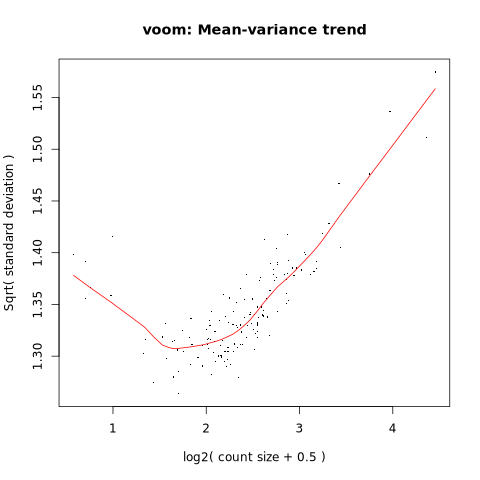

In [13]:
%%R
library(edgeR)
library(limma)

pseudo_csv <- "../../data/processed/pancancer_pseudobulk_counts.csv"

# Load pseudobulk counts (samples × genes)
counts <- read.csv(pseudo_csv, row.names=1, check.names=FALSE)

# Create DGEList and normalize
dge <- DGEList(counts=counts)
dge <- calcNormFactors(dge)

# Apply voom
v <- voom(dge, plot=TRUE)

# Save voom-transformed matrix
voom_csv <- "../../data/processed/pancancer_pseudobulk_voom.csv"
write.csv(v$E, file=voom_csv)

cat("✅ Voom-transformed data saved to:", voom_csv, "\n")


In [ ]:
# Reload voom-transformed CSV
voom_df = pd.read_csv("../../data/processed/pancancer_pseudobulk_voom.csv", index_col=0)

# Save as parquet (canonical format for downstream ML)
voom_parquet = "../../data/processed/pancancer_pseudobulk_voom.parquet"
voom_df.to_parquet(voom_parquet, engine="pyarrow", compression="snappy")

print(f"✅ Final voom-transformed pseudobulk saved as parquet: {voom_parquet}")


✅ Final voom-transformed pseudobulk saved as parquet: ../../data/processed/pancancer_pseudobulk_voom.parquet


In [3]:
import pandas as pd
from sklearn.decomposition import PCA

# Load voom-transformed pseudobulk
voom_df = pd.read_parquet("../../data/processed/pancancer_pseudobulk_voom.parquet")

print("✅ Loaded voom-transformed pseudobulk:", voom_df.shape)

# Run PCA (keep 30 PCs)
pca = PCA(n_components=30, random_state=42)
pcs = pca.fit_transform(voom_df)

# Build PC dataframe
pcs_df = pd.DataFrame(
    pcs,
    index=voom_df.index,
    columns=[f"PC{i+1}" for i in range(30)]
).reset_index().rename(columns={"index": "SANGER_MODEL_ID"})

print("✅ PCA complete:", pcs_df.shape)

# Save PCs
pcs_parquet = "../../data/processed/pseudobulk_voom_30_pcs.parquet"

pcs_df.to_parquet(pcs_parquet, engine="pyarrow", compression="snappy")

print(f"💾 Saved 30-PC pseudobulk to:\n - {pcs_parquet}")

print(pcs_df.head())


✅ Loaded voom-transformed pseudobulk: (140, 26764)
✅ PCA complete: (140, 31)
💾 Saved 30-PC pseudobulk to:
 - ../../data/processed/pseudobulk_voom_30_pcs.parquet
  SANGER_MODEL_ID         PC1        PC2        PC3        PC4        PC5  \
0       SIDM00078   32.142179  55.102789  59.885132  23.702440  27.181169   
1       SIDM00080  139.328583 -81.616457 -87.758810  52.388116  56.958351   
2       SIDM00082    6.320749 -69.621792 -26.008813  37.136489  63.180254   
3       SIDM00088   -7.741707 -21.503488   3.860633 -32.538583 -21.732919   
4       SIDM00092  162.765686  40.331206 -19.539950  -8.371106 -21.425242   

         PC6        PC7        PC8        PC9  ...       PC21       PC22  \
0  41.637502 -33.316560 -22.922811  17.319023  ...  29.621952  27.931930   
1 -16.221151 -42.707925  15.109891   1.913957  ...  -6.876905  23.846832   
2  12.701162 -14.193844  -0.831124   5.205879  ...   3.631547  24.030283   
3  -2.873913 -12.733508   8.648297  -2.059005  ...   1.882217  10.788825